In [491]:
## Importing important libraries
import yfinance as yf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


## Making the Momentum Strategy backtesting functions
class MomentumStrategy():


    ## Initialising the function
    def __init__(self, symbol, SMA, EMA, RSI, start, end):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.RSI = RSI
        self.start = start
        self.end = end
        self.results = None
        self.get_data()

    
    def get_data(self):

        ## Downloading the stock data and converting the prices to Datafrane
        df = yf.download(self.symbol, start = self.start, end = self.end)
        data = df["Close"].to_frame()

        ## Calculating Gains and Losses for RSI Calculation
        data["Change"] = data["Close"] - data["Close"].shift(1)
        data["Gain"] = np.where(data["Change"] >= 0, data["Change"], 0)
        data["Loss"] = np.where(data["Change"] <= 0, data["Change"], 0)
        data["Av_Gain"] = data["Gain"].ewm(span=self.RSI, min_periods=self.RSI).mean()
        data["Av_Loss"] = data["Loss"].ewm(span=self.RSI, min_periods=self.RSI).mean()

        ## Calculating RSI (both versions)
        data["RSI1"] = (100 - ( 100 / (1+(data["Av_Gain"].div(abs(data["Av_Loss"]))))))
        data["RSI2"] = (100 - ( 100 / (1+((data["Av_Gain"].shift(1)*(self.RSI - 1) + data["Av_Gain"]) / (abs(data["Av_Loss"].shift(1)*(self.RSI - 1)) + data["Av_Loss"])))))
        
        ## Calculating the Simple and Exponential Moving Averages
        data["EMA"] = data["Close"].ewm(span=self.EMA, min_periods=self.EMA).mean()
        data["SMA"] = data["Close"].rolling(window=self.SMA, min_periods=self.SMA).mean()

        ## Storing filtered data for backtest
        data.dropna(inplace=True)
        self.data2 = data

        return data 

    
    def backtest(self):
        data = self.data2.copy().dropna()

        ## Calculating normal (Buy and Hold) returns
        data["Returns"] = np.log(data["Close"].div(data["Close"].shift(1))).cumsum()

        ## Strategy Logic - Buy when EMA goes over SMA, short when SMA goes over EMA
        data["Strategy"] = np.where(data["EMA"] >= data["SMA"], 1, -1)
        
        ## Take Profit Condition - Close long position when RSI>90 & short position when RSI<15
        stoplong = (data["Strategy"] == 1) & (data["RSI1"] >= 80) & (data["RSI2"] >= 80)
        stopshort = (data["Strategy"] == -1) & (data["RSI1"] <= 20) & (data["RSI2"] <= 20)
        data.loc[ stoplong | stopshort, "Strategy"] = 0


        ## Calculating our Strategy Returns
        data["ReturnsStrategy"] = (np.log(data["Close"].div(data["Close"].shift(1))) * data["Strategy"].shift(1)).cumsum()
        data.dropna(inplace=True)
        self.results = data
        self.data3 = data

        return data

    
    ## Backtesting Results
    def testresults(self):
        if self.results is None:
            print("Run Backtest through .backtest()")
        else:
            data = self.data3.copy().dropna()
            perf = data.loc[-1, "ReturnsStrategy"]
            outperf = perf - data["Returns"].iloc[-1]
            data[["Returns","ReturnsStrategy"]].plot(figsize=(16,12), fontsize=14, xlabel="Date", ylabel="Returns")
            plt.title("{} | EMA{} | SMA{} | RSI Period: {}".format(self.symbol, self.EMA, self.SMA, self.RSI), fontsize=24)
            plt.legend(fontsize=14)
            plt.show()

            return outperf 


    ## Strategy Graph
    def strategy(self):
        if self.results is None:
            print("Run Backtest through .backtest()")
        else:
            data = self.data3.copy().dropna()
            graphdata = data[["Close", "EMA", "SMA", "RSI1", "RSI2"]].copy()
            graph, axis = plt.subplots(2)
            axis[0].plot(graphdata[["Close", "EMA", "SMA"]])
            axis[0].set_title("Prices & Strategy")
            axis[0].legend(["Close", "EMA", "SMA"])
            axis[0].set_xlabel("Date")
            axis[0].set_ylabel("Price$")
            axis[1].plot(graphdata[["RSI1", "RSI2"]])
            axis[1].set_title("Relative Strength Index Indicator")
            axis[1].legend(["RSI1", "RSI2"])
            axis[1].set_xlabel("Date")
            axis[1].set_ylabel("RSI")
            graph.set_figheight(20)
            graph.set_figwidth(16)
            plt.legend(fontsize=14)
            plt.show


In [493]:
Test = MomentumStrategy("V", 26, 100, 50, "2019-01-01", "2024-01-01")
Test.backtest()

[*********************100%%**********************]  1 of 1 completed


,Close,Change,Gain,Loss,Av_Gain,Av_Loss,RSI1,RSI2,EMA,SMA,Returns,Strategy,ReturnsStrategy
Date,,,,,,,,,,,,,
2019-05-28,163.710007,1.070007,1.070007,0.000000,0.688385,-0.480166,58.909297,58.337022,155.871087,162.096922,0.006557,-1,-0.006557
2019-05-29,162.729996,-0.980011,0.000000,-0.980011,0.660926,-0.500105,56.925795,59.895346,156.027205,162.186538,0.000553,-1,-0.000553
2019-05-30,162.759995,0.029999,0.029999,0.000000,0.635775,-0.480169,56.971953,57.885011,156.180001,162.228845,0.000738,-1,-0.000738
2019-05-31,161.330002,-1.429993,0.000000,-1.429993,0.610448,-0.518007,54.095890,57.990293,156.296539,162.222691,-0.008087,-1,0.008087
2019-06-03,158.600006,-2.729996,0.000000,-2.729996,0.586144,-0.606072,49.164274,55.175819,156.348517,162.129614,-0.025154,-1,0.025154
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,258.429993,-1.110016,0.000000,-1.110016,0.986417,-0.655808,60.065890,62.657157,244.823913,255.628846,0.463086,-1,0.425878
2023-12-26,259.160004,0.730011,0.730011,0.000000,0.976361,-0.630090,60.777539,61.016664,245.107796,256.036153,0.465906,-1,0.423057
2023-12-27,258.929993,-0.230011,0.000000,-0.230011,0.938073,-0.614400,60.424415,61.715488,245.381503,256.396538,0.465019,-1,0.423945


In [495]:
Test.testresults()

KeyError: -1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


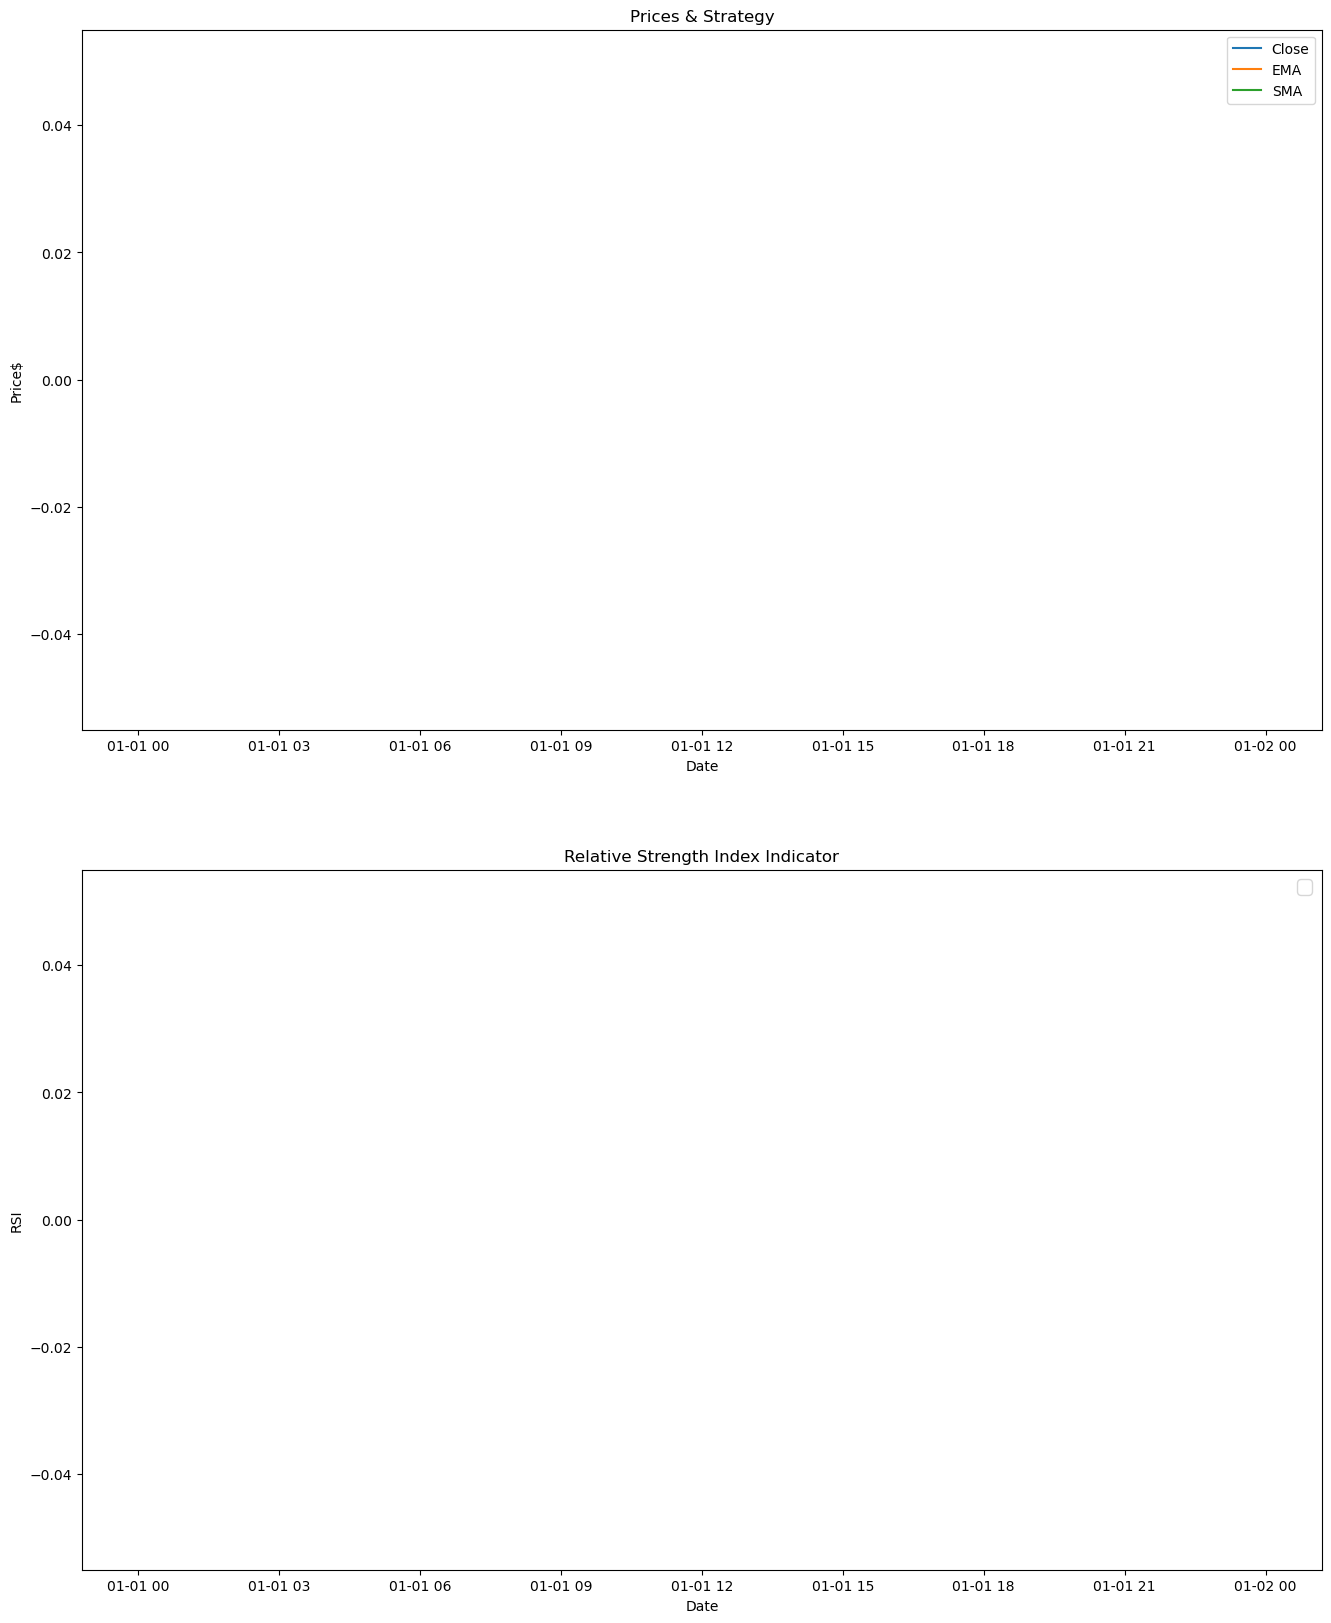

In [458]:
Test.strategy()

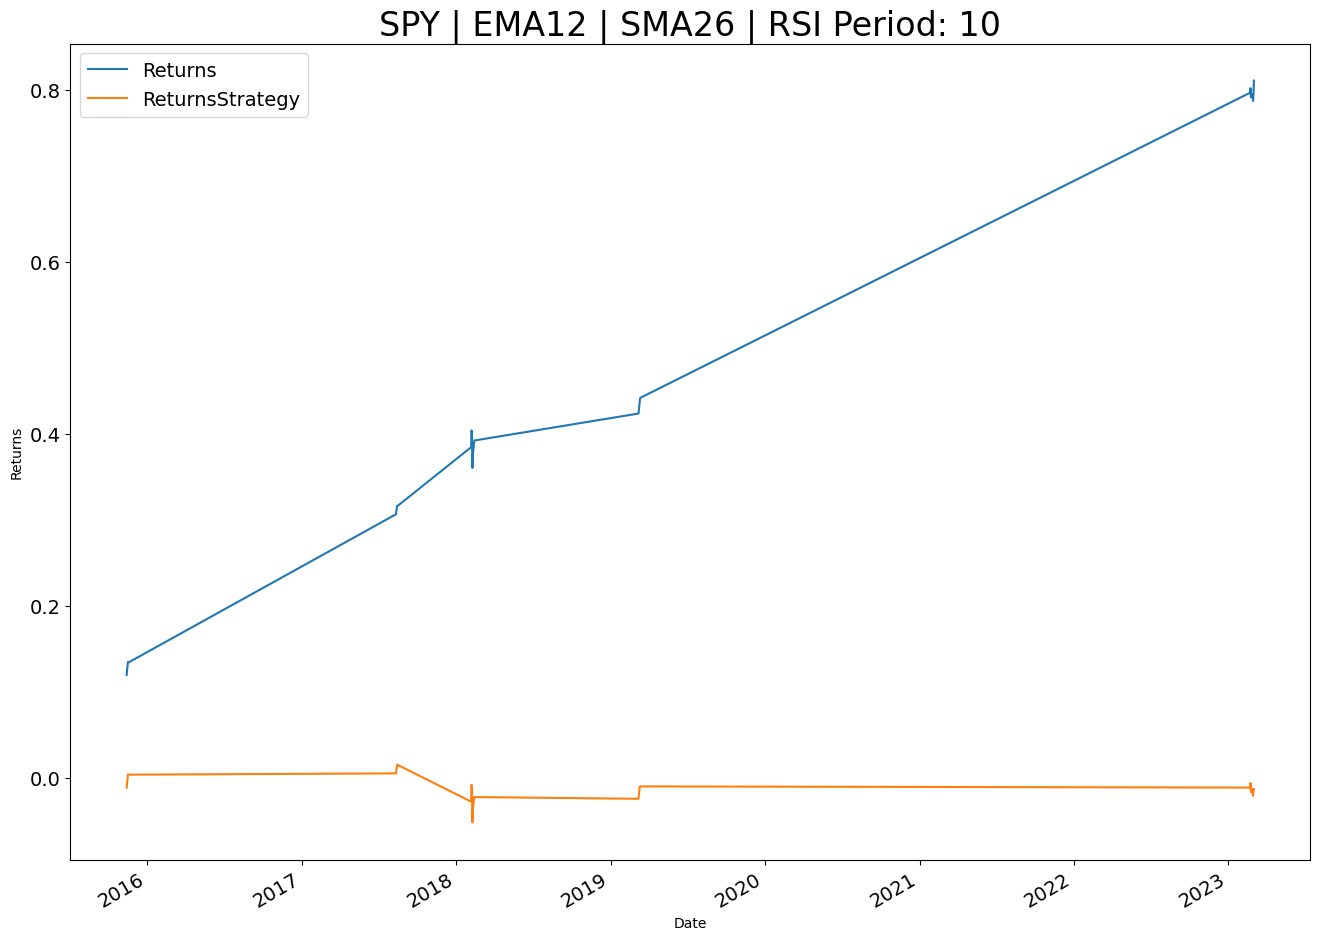

-0.8237783934405132